# Step 3 — Machine Learning (Startup Success Prediction)

## Goal
Build and evaluate classification models that predict `success` (0/1) using the engineered features from Step 2.

## Data
We use the processed dataset exported at the end of Step 2:
`data/processed/step2_dataset.parquet`

## Methodology (high-level)
1. Load and sanity-check data
2. Define target (`success`) and features (X)
3. Train/test split (stratified)
4. Preprocess (impute + scale numeric, encode categorical if any)
5. Train baseline + compare multiple models
6. Hyperparameter tuning with cross-validation
7. Evaluate with confusion matrix, accuracy, precision, recall, ROC-AUC (and threshold sensitivity)
8. Interpret results and discuss limitations


In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1) Load data and sanity checks
We load the Step 2 processed dataset and check:
- shape
- missing values (especially in target)
- class balance of `success`


In [2]:
path = "data/processed/step2_dataset.parquet"
df = pd.read_parquet(path)

print("Shape:", df.shape)
display(df.head())

# Target check
if "success" not in df.columns:
    raise ValueError("Column `success` not found in dataframe.")

print("\nMissing in success:", df["success"].isna().sum())
print("\nClass distribution:")
print(df["success"].value_counts(dropna=False))

prevalence = df["success"].dropna().mean()
print(f"\nPrevalence (mean success) = {prevalence:.3f}")


Shape: (921, 82)


,state_code,latitude,longitude,zip_code,id,city,name,labels,founded_at,closed_at,...,early_total_funding_usd,early_round_count,age_years_outcome,age_bin_3,rel_per_round,has_seed,other_stage_sum,seed_only,seed_share_total,seed_over_avg_round
0,CA,42.358880,-71.056820,92101,c:6669,San Diego,Bandsintown,1,2007-01-01,NaT,...,0.0,0.0,3.000684,0-5,1.000000,False,0.0,False,NaN,NaN
1,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,TriCipher,1,2000-01-01,NaT,...,0.0,0.0,9.990418,5-10,2.250000,False,37100000.0,False,0.000000,0.000000
2,CA,32.901049,-117.192656,92121,c:65620,San Diego,Plixi,1,2009-03-18,NaT,...,2600000.0,1.0,1.032170,0-5,5.000000,False,2600000.0,False,0.000000,0.000000
3,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Solidcore Systems,1,2002-01-01,NaT,...,0.0,0.0,5.311431,5-10,1.666667,False,40000000.0,False,0.000000,0.000000
4,CA,37.779281,-122.419236,94105,c:65806,San Francisco,Inhale Digital,0,2010-08-01,2012-10-01,...,1100000.0,1.0,2.168378,0-5,1.000000,True,0.0,True,0.846154,1.692308



Missing in success: 0

Class distribution:
1    596
0    325
Name: success, dtype: int64

Prevalence (mean success) = 0.647


## 2) Define target and feature set

We start with a focused feature list (mostly from Step 2 analysis) to build a clean baseline.
Then we can expand to a wider set if needed.


In [3]:
target_col = "success"

base_features = [
    "rel_per_round",
    "avg_participants",
    "age_first_funding_year",
    "early_total_funding_usd",
    "seed_share_total",
    "seed_over_avg_round",
]

# keep only existing columns
base_features = [c for c in base_features if c in df.columns]
print("Using base features:", base_features)

work = df.dropna(subset=[target_col]).copy()
X = work[base_features].copy()
y = work[target_col].astype(int).copy()

print("X shape:", X.shape, "| y shape:", y.shape)


Using base features: ['rel_per_round', 'avg_participants', 'age_first_funding_year', 'early_total_funding_usd', 'seed_share_total', 'seed_over_avg_round']
X shape: (921, 6) | y shape: (921,)


## 3) Train-test split (stratified)
We split data into train/test while preserving class balance.


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train class distribution:\n", y_train.value_counts(normalize=True))
print("\nTest class distribution:\n", y_test.value_counts(normalize=True))


Train class distribution:
 1    0.646739
0    0.353261
Name: success, dtype: float64

Test class distribution:
 1    0.648649
0    0.351351
Name: success, dtype: float64


## 4) Preprocessing
- Numeric: impute missing values with median, then standardize
- Categorical (if any): impute most frequent, then one-hot encode
We use `ColumnTransformer` + `Pipeline` for clean and leak-free preprocessing.


In [5]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X_train.columns if c not in numeric_features]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)


Numeric: ['rel_per_round', 'avg_participants', 'age_first_funding_year', 'early_total_funding_usd', 'seed_share_total', 'seed_over_avg_round']
Categorical: []


## 5) Evaluation helper
We evaluate models with:
- confusion matrix
- accuracy, precision, recall
- ROC-AUC (threshold-independent)
We also test two thresholds:
- 0.50
- prevalence (as suggested in course material)


In [6]:
def evaluate_model(name, fitted_pipeline, X_test, y_test, threshold=0.5):
    proba = fitted_pipeline.predict_proba(X_test)[:, 1]
    pred = (proba >= threshold).astype(int)

    cm = confusion_matrix(y_test, pred)
    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred, zero_division=0)
    rec = recall_score(y_test, pred, zero_division=0)
    auc = roc_auc_score(y_test, proba)

    return {
        "model": name,
        "threshold": threshold,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "roc_auc": auc,
        "confusion_matrix": cm
    }


## 6) Baseline model — Logistic Regression
We fit a simple baseline to establish a reference performance.


In [7]:
logreg = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

logreg.fit(X_train, y_train)

res_lr_05 = evaluate_model("LogReg", logreg, X_test, y_test, threshold=0.5)
res_lr_prev = evaluate_model("LogReg", logreg, X_test, y_test, threshold=float(prevalence))

print("LogReg @0.5:", {k:v for k,v in res_lr_05.items() if k!="confusion_matrix"})
print("Confusion:\n", res_lr_05["confusion_matrix"])

print("\nLogReg @prevalence:", {k:v for k,v in res_lr_prev.items() if k!="confusion_matrix"})
print("Confusion:\n", res_lr_prev["confusion_matrix"])


LogReg @0.5: {'model': 'LogReg', 'threshold': 0.5, 'accuracy': 0.654054054054054, 'precision': 0.7857142857142857, 'recall': 0.6416666666666667, 'roc_auc': 0.7234615384615385}
Confusion:
 [[44 21]
 [43 77]]

LogReg @prevalence: {'model': 'LogReg', 'threshold': 0.6471226927252985, 'accuracy': 0.5351351351351351, 'precision': 0.8541666666666666, 'recall': 0.3416666666666667, 'roc_auc': 0.7234615384615385}
Confusion:
 [[58  7]
 [79 41]]


## 7) Model comparison + hyperparameter tuning
We compare:
- Decision Tree (tuned with GridSearchCV)
- Random Forest (tuned with GridSearchCV)
We optimize ROC-AUC using 5-fold cross-validation.


In [8]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)

dummy_pred = dummy.predict(X_test)
dummy_acc = accuracy_score(y_test, dummy_pred)

print("Dummy (always majority class) accuracy:", dummy_acc)
print("Test prevalence (majority rate):", y_test.mean())


Dummy (always majority class) accuracy: 0.6486486486486487
Test prevalence (majority rate): 0.6486486486486487


In [9]:
results = []
results.extend([res_lr_05, res_lr_prev])

# ---- Decision Tree ----
tree = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", DecisionTreeClassifier(
        random_state=RANDOM_STATE,
        class_weight="balanced"
    ))
])

tree_grid = {
    "clf__max_depth": [3, 5, 8, None],
    "clf__min_samples_split": [2, 10, 30],
    "clf__min_samples_leaf": [1, 5, 10],
}

tree_gs = GridSearchCV(
    tree,
    param_grid=tree_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)
tree_gs.fit(X_train, y_train)

best_tree = tree_gs.best_estimator_
print("Best DecisionTree params:", tree_gs.best_params_)

results.append(evaluate_model("DecisionTree(GS)", best_tree, X_test, y_test, threshold=0.5))
results.append(evaluate_model("DecisionTree(GS)", best_tree, X_test, y_test, threshold=float(prevalence)))

# ---- Random Forest ----
rf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=RANDOM_STATE,
        class_weight="balanced_subsample",
        n_jobs=-1
    ))
])

rf_grid = {
    "clf__max_depth": [None, 5, 10],
    "clf__min_samples_split": [2, 10, 30],
    "clf__min_samples_leaf": [1, 5, 10],
}

rf_gs = GridSearchCV(
    rf,
    param_grid=rf_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)
rf_gs.fit(X_train, y_train)

best_rf = rf_gs.best_estimator_
print("Best RandomForest params:", rf_gs.best_params_)

results.append(evaluate_model("RandomForest(GS)", best_rf, X_test, y_test, threshold=0.5))
results.append(evaluate_model("RandomForest(GS)", best_rf, X_test, y_test, threshold=float(prevalence)))

summary = pd.DataFrame(results).drop(columns=["confusion_matrix"])
display(summary.sort_values(["roc_auc", "accuracy"], ascending=False))

print("\nConfusion matrices:")
for r in results:
    print(f"\n{r['model']} | threshold={r['threshold']}")
    print(r["confusion_matrix"])


Best DecisionTree params: {'clf__max_depth': 5, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 30}
Best RandomForest params: {'clf__max_depth': 5, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10}


,model,threshold,accuracy,precision,recall,roc_auc
4,RandomForest(GS),0.500000,0.740541,0.790323,0.816667,0.787821
5,RandomForest(GS),0.647123,0.654054,0.841463,0.575000,0.787821
3,DecisionTree(GS),0.647123,0.718919,0.809091,0.741667,0.762628
2,DecisionTree(GS),0.500000,0.713514,0.772358,0.791667,0.762628
0,LogReg,0.500000,0.654054,0.785714,0.641667,0.723462
1,LogReg,0.647123,0.535135,0.854167,0.341667,0.723462



Confusion matrices:

LogReg | threshold=0.5
[[44 21]
 [43 77]]

LogReg | threshold=0.6471226927252985
[[58  7]
 [79 41]]

DecisionTree(GS) | threshold=0.5
[[37 28]
 [25 95]]

DecisionTree(GS) | threshold=0.6471226927252985
[[44 21]
 [31 89]]

RandomForest(GS) | threshold=0.5
[[39 26]
 [22 98]]

RandomForest(GS) | threshold=0.6471226927252985
[[52 13]
 [51 69]]


In [10]:
# Cross-validated ROC-AUC scores from GridSearchCV (train set only)
# (tree_gs and rf_gs are defined in the previous cell)
print(f"DecisionTree CV best ROC-AUC: {tree_gs.best_score_:.6f}")
print(f"RandomForest CV best ROC-AUC: {rf_gs.best_score_:.6f}")


DecisionTree CV best ROC-AUC: 0.730781
RandomForest CV best ROC-AUC: 0.773816


In [11]:
from sklearn.metrics import f1_score, balanced_accuracy_score

def threshold_sweep(pipeline_model, X_test, y_test, thresholds=np.linspace(0.1, 0.9, 17)):
    proba = pipeline_model.predict_proba(X_test)[:, 1]
    rows = []
    for t in thresholds:
        pred = (proba >= t).astype(int)
        rows.append({
            "threshold": float(t),
            "accuracy": accuracy_score(y_test, pred),
            "balanced_acc": balanced_accuracy_score(y_test, pred),
            "precision": precision_score(y_test, pred, zero_division=0),
            "recall": recall_score(y_test, pred, zero_division=0),
            "f1": f1_score(y_test, pred, zero_division=0),
        })
    return pd.DataFrame(rows)

sweep_rf = threshold_sweep(best_rf, X_test, y_test)
display(sweep_rf.sort_values("f1", ascending=False).head(10))


,threshold,accuracy,balanced_acc,precision,recall,f1
2,0.20,0.729730,0.615385,0.705882,1.000000,0.827586
3,0.25,0.740541,0.648397,0.727848,0.958333,0.827338
4,0.30,0.745946,0.670192,0.744966,0.925000,0.825279
7,0.45,0.740541,0.701282,0.781250,0.833333,0.806452
6,0.40,0.735135,0.686538,0.766917,0.850000,0.806324
5,0.35,0.724324,0.657051,0.741259,0.883333,0.806084
8,0.50,0.740541,0.708333,0.790323,0.816667,0.803279
1,0.15,0.675676,0.538462,0.666667,1.000000,0.800000
0,0.10,0.664865,0.523077,0.659341,1.000000,0.794702
9,0.55,0.724324,0.706410,0.800000,0.766667,0.782979


### Note on threshold choice (why we report multiple operating points)

Our dataset is moderately imbalanced (~65% success, ~35% failure). Because of this:

- **Accuracy can be misleading**: predicting the majority class for everyone already gives ~0.65 accuracy (see Dummy baseline).
- **ROC-AUC** evaluates ranking quality independent of a threshold, so we use it for model comparison.
- The **decision threshold** should reflect the cost of mistakes:
  - If missing a successful startup is expensive (**false negative**), we prefer **higher recall** → use a **lower threshold** (e.g., ~0.25–0.30 in the sweep).
  - If predicting success incorrectly is expensive (**false positive**), we prefer **higher precision** → use a **higher threshold**.

In this notebook we report:
- the common default **0.50**, and
- a **threshold sweep** to visualize the precision–recall trade-off and pick an operating point based on the goal.


<Figure size 640x480 with 0 Axes>

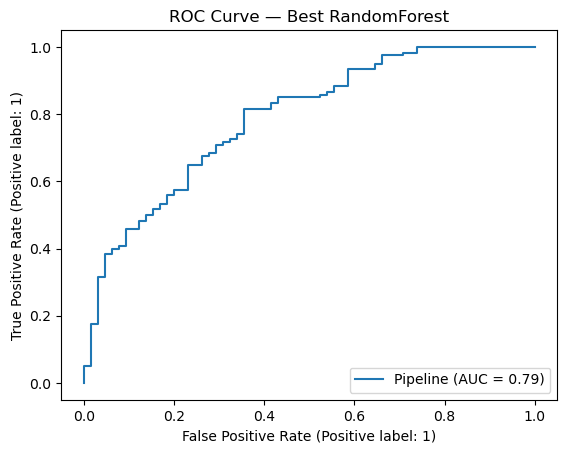

<Figure size 640x480 with 0 Axes>

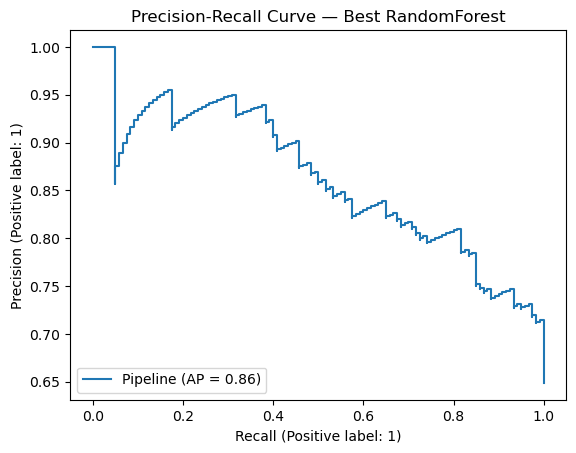

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

plt.figure()
RocCurveDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("ROC Curve — Best RandomForest")
plt.show()

plt.figure()
PrecisionRecallDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("Precision-Recall Curve — Best RandomForest")
plt.show()


## 8) Interpretation
We inspect feature importances from the best Random Forest model to understand which variables contribute most to prediction.


In [13]:
# Inspect feature importances from the best Random Forest model
# to understand which variables contribute most to prediction.

def get_feature_names(preprocess, numeric_features, categorical_features):
    """Return feature names after ColumnTransformer preprocessing."""
    # If sklearn supports get_feature_names_out on ColumnTransformer, use it.
    try:
        names = preprocess.get_feature_names_out().tolist()
        # Clean up prefixes like 'num__' / 'cat__'
        names = [n.split('__', 1)[-1] for n in names]
        return names
    except Exception:
        # Fallback: manual assembly
        feature_names = []
        feature_names.extend(numeric_features)

        if len(categorical_features) > 0:
            ohe = preprocess.named_transformers_["cat"].named_steps["onehot"]
            cat_names = ohe.get_feature_names_out(categorical_features).tolist()
            feature_names.extend(cat_names)

        return feature_names

# Get names from the fitted preprocessor inside the best_rf pipeline
prep_fitted = best_rf.named_steps["prep"]
feat_names = get_feature_names(prep_fitted, numeric_features, categorical_features)

importances = best_rf.named_steps["clf"].feature_importances_
imp_df = (
    pd.DataFrame({"feature": feat_names, "importance": importances})
      .sort_values("importance", ascending=False)
      .reset_index(drop=True)
)

display(imp_df.head(15))


,feature,importance
0,rel_per_round,0.403990
1,avg_participants,0.219978
2,age_first_funding_year,0.148367
3,early_total_funding_usd,0.106460
4,seed_share_total,0.068915
5,seed_over_avg_round,0.052290


## 9) Conclusion & limitations

### Key findings
- **Baseline (majority class) accuracy:** ~0.649 (Dummy classifier), so accuracy alone is not enough.
- **Best model (by ROC-AUC on test):** **RandomForest (tuned)** with **ROC-AUC ≈ 0.788**.
- **Threshold sensitivity matters:**
  - At **threshold = 0.50** (standart default): accuracy ≈ **0.741**, precision ≈ **0.790**, recall ≈ **0.817**.
  - At a **lower threshold (~0.25–0.30)** (recall-oriented): recall can increase to **~0.925–0.958**, with more false positives.
- **Most important features (RandomForest):** `rel_per_round` (highest), `avg_participants`, `age_first_funding_year`, `early_total_funding_usd`, then seed-related ratios.

### Limitations
- **Small feature set:** Only 6 numeric features are used; richer pre-funding signals could improve generalization.
- **Potential leakage risk:** Funding-related variables may indirectly encode post-outcome dynamics depending on how the dataset was constructed.
- **Threshold selection:** In a production setting, the threshold should be chosen on a validation set (or within CV), not on the test set.
- **Imbalance & costs:** The “best” model/threshold depends on the real-world cost of false positives vs false negatives.
